Correlation between Features

The correlation matrix depicting the correlation of explanatory variables is shown directly below:
          AGE       SEX       BMI        BP        S1        S2        S3  \
AGE  1.000000  0.173737  0.185085  0.335428  0.260061  0.219243 -0.075181   
SEX  0.173737  1.000000  0.088161  0.241010  0.035277  0.142637 -0.379090   
BMI  0.185085  0.088161  1.000000  0.395411  0.249777  0.261170 -0.366811   
BP   0.335428  0.241010  0.395411  1.000000  0.242464  0.185548 -0.178762   
S1   0.260061  0.035277  0.249777  0.242464  1.000000  0.896663  0.051519   
S2   0.219243  0.142637  0.261170  0.185548  0.896663  1.000000 -0.196455   
S3  -0.075181 -0.379090 -0.366811 -0.178762  0.051519 -0.196455  1.000000   
S4   0.203841  0.332115  0.413807  0.257650  0.542207  0.659817 -0.738493   
S5   0.270774  0.149916  0.446157  0.393480  0.515503  0.318357 -0.398577   
S6   0.301731  0.208133  0.388680  0.390430  0.325717  0.290600 -0.273697   

           S4        S5        S6  
AGE  0.203841  0.

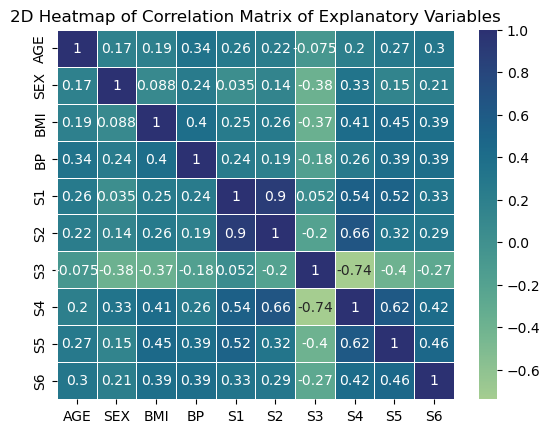

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           3.83e-62
Time:                        19:09:37   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -334.5671     67.455     -4.960      0.0

In [4]:
# Library Importation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf


# Data Importation
diabetes_data = pd.read_excel("Diabetes_Data.xlsx")

# Correlation Matrix Generation
corr_matrix = diabetes_data.loc[:,:'S6'].corr()
print("The correlation matrix depicting the correlation of explanatory variables is shown directly below:")
print(corr_matrix)

# Heat Map Visualization
sns.heatmap(corr_matrix, linewidths=0.5, annot=True, cmap="crest")
plt.title("2D Heatmap of Correlation Matrix of Explanatory Variables")
plt.show()

# Generating Features and Dependent Variables Separately
features = diabetes_data.loc[:,:'S6']
y = diabetes_data[['Y']]

# Adding Constant
features = sm.add_constant(features)

# Regression Model
model1 = sm.OLS(y, features).fit()
y_pred = model1.predict(features)
print(model1.summary())
print("")

print("SUMMARY STATS FOR REGRESSION MODEL WITH ALL VARIABLES")
print("-"*60)

# R2 score for Basic Regression Model
print(f"The Adjusted R2 Score for MODEL 1 with all variables is: {model1.rsquared_adj}")

# Mean square error calculation
mse_all = mse(y.values.flatten(), y_pred.values) # y is a dataframe and y_pred is a series
print(f"The mean square error for MODEL 1 with all variables is: {round(mse_all,4)}%")
print("\n")

# Forward Feature Selection
all_var = list(diabetes_data.columns) # list of all variables
dep_var = all_var[-1] # list of dependent variables
ind_var = all_var[:-1] # list of independent variables
feature_list = ind_var.copy() # list of features that will be used in forward regression

x_data = diabetes_data.loc[:,:'S6']
selected_features = []
ind_varset = set(ind_var)

print("INTERACTIVE STEPWISE FORWARD SELECTION")
print("-"*60)

def stepwise(sig_level):
    """
        This function receives the level of significance
        and selects the chosen features using forward
        regression.
    """
    while True:
        loop_break = 0
        residual_features = ind_varset-set(selected_features)
        residual_features = list(residual_features) # turning residual features into a list
        pval_residual = pd.Series(index=residual_features, dtype='float64')
        for feature in residual_features:
            index = selected_features + [feature] # pairing up selected features with unselected features in an index variable
            x_data_const = sm.add_constant(x_data[index])
            step_model = sm.OLS(y, x_data_const).fit()
            pval_residual[feature] = step_model.pvalues[feature]
        selected_pval = pval_residual.min()
        if selected_pval < sig_level:
            chosen_feature = pval_residual.idxmin()
            selected_features.append(chosen_feature)
            print(f"{chosen_feature} has been added to the list of selected predictors")
            print(f"Current list of selected predictors is: {selected_features}")
            loop_break = 1 # Acts as a value to help in breaking out of the loop
        if not loop_break:
            break

    print(f"Final list of selected features are: {selected_features}")
    return selected_features

variables_stepwise = stepwise(0.05) # List of selected variables using stepwise forward selection

# Getting R2 Score and MSE for Stepwise
print("\n")
print("SUMMARY STATS FOR REGRESSION MODEL WITH ALL VARIABLES")
print("-"*60)

# Building Model with Chosen Variables
step_model_chosen = sm.OLS(y,sm.add_constant(x_data[variables_stepwise])).fit()
x_step = sm.add_constant(x_data[variables_stepwise])
ypred_step = step_model_chosen.predict(x_step)
print(f"The R2 Score for the stepwise regression model with chosen variables is: {step_model_chosen.rsquared}")

# Mean square error calculation
mse_step = mse(y.values.flatten(), ypred_step.values) # y is a dataframe and y_pred is a series
print(f"The mean square error for the stepwise regression model with chosen variables using forward selection is: {round(mse_step,4)}%")
print("\n")


Logistic Regression

In [6]:
import numpy as np
import pandas as pd
from pandas import value_counts
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import statsmodels.api as sm


# Data Importation
titanic_data = pd.read_csv("titanic3.csv")
titanic_data = titanic_data.loc[:,['pclass','survived','sex','age']] # selection of vital columns

survived = titanic_data['survived']
sum_survived = survived.sum() # finding the toal sum of survived passengers
prob_survived = sum_survived/len(survived) 
print(f" Probability of survival for a passenger on the titanic is: {round(prob_survived,4)}") # probability of survival of a passenger on the titanic
print("\n")

age_mean = titanic_data[['age']].mean() # Getting mean for age
titanic_data = titanic_data.fillna(age_mean) # fillna for age to remove nan values

age_class = ['Children (0 - 12)', 'Teenagers (13 - 19)', 'Young Adults (20 - 35)', 'Adults (36 - 50)', 'Elderly (51 - ∞)'] # defining the age categories

def age_divide(age_class, dataset):
    """
        This function extracts the age into different categories
        and creates an age class on the titanic dataset
    """
    dataset['age_class'] = 'blah'
    for i in age_class:
        if i == age_class[0]:
            condition = (dataset['age'] >= 0) & (dataset['age'] <= 12)
            dataset.loc[condition, 'age_class'] = i
        elif i == age_class[1]:
            condition = (dataset['age']>=13) & (dataset['age']<=19)
            dataset.loc[condition, 'age_class'] = i
        elif i == age_class[2]:
            condition = (dataset['age']>=20) & (dataset['age']<=35)
            dataset.loc[condition, 'age_class'] = i
        elif i == age_class[3]:
            condition = (dataset['age']>=36) & (dataset['age']<=50)
            dataset.loc[condition, 'age_class'] = i
        elif i == age_class[4]:
            condition = (dataset['age']>=51)
            dataset.loc[condition, 'age_class'] = i

    return dataset

titanic_data = age_divide(age_class, titanic_data) # generate the age class column and append it to the table

def prob_class(classtr, dataset):
    """
        probability of any class you pass to it.
    """
    class_unique = dataset[classtr].value_counts().index.values.tolist()
    class_unique.sort()
    p_class = dict() # dictionary to store probability with respect to classes
    for i in class_unique:
        values_to_sum = dataset.loc[dataset[classtr]==i] # finding positions where the data equals an item of the class
        sum_class = values_to_sum['survived'].sum()
        prob = sum_class/len(values_to_sum[classtr]) # calculating the probability for each class
        p_class[i] = prob
    return p_class

gender_prob = prob_class('sex', titanic_data) # gender probability
pclass_prob = prob_class('pclass', titanic_data) # pclass probability
age_prob = prob_class('age_class', titanic_data) # age probability

def multindex_dict(class_name, prob_dict):
    """
        Generating a multindex dicitionary for a
        probability class to help build a 
        multi-index pandas table
    """
    data_dict = {}
    for i in prob_dict.keys():
        data_dict[(class_name, i)] = prob_dict[i]
    return data_dict


# Multindices generation for pclass, gender and age
pclass_probdict = multindex_dict('pclass', pclass_prob)
gender_probdict = multindex_dict('Gender / Sex', gender_prob)
age_probdict = multindex_dict('Age', age_prob)

# Creating a dictionary which will be used to generate the original dataframe
dict_table = dict()
dict_table.update(pclass_probdict)
dict_table.update(gender_probdict)
dict_table.update(age_probdict)

# Generating of table showing probability for each class
prob_table = pd.DataFrame(dict_table.values(), index = dict_table.keys())
prob_table.columns = ['Probability']
print(prob_table)


# Logistic Regression
# Conversion of Categorical Data to Dummy Variables
sex = pd.get_dummies(titanic_data['sex'], drop_first = True)
sex.columns = ['sex'] # 0 is female and 1 is male
titanic_data['sex'] = sex

# Extracting X and Y data
x_data = titanic_data.loc[:, ['pclass', 'sex', 'age']]
y_data = titanic_data['survived']
Xtrain_data, Xtest_data, ytrain_data, ytest_data = train_test_split(x_data, y_data, test_size = 0.2, random_state=0)

# Feature Scaling on X data
std_scaler = StandardScaler()
X_trainset = std_scaler.fit_transform(Xtrain_data)
X_testset = std_scaler.transform(Xtest_data)

# Building Logistic Regression Model
logstats_mod = sm.Logit(ytrain_data, X_trainset).fit(disp=0)

# Model Coefficients | Parameter Estimates
# To get the coefficients, we use statsmodels
print("\n")
print(logstats_mod.summary()) # printing summary results
print("\n")
print(f"Parameter Estimates or Coefficients of the model are: \n{logstats_mod.params}\n")

# Prediction
ypred_data = logstats_mod.predict(X_testset)
ypred_data = list(map(round, ypred_data))

# Confusion Matrix
confusion_mat = confusion_matrix(ytest_data, ypred_data)
print(f"Confusion Matrix is : \n{confusion_mat}\n")

tptn = confusion_mat[0][0] + confusion_mat[1][1] # number of true positives and negatives
fpfn = confusion_mat[0][1] + confusion_mat[1][0] # number of false positives and negatives

class_accuracy = tptn/(tptn+fpfn) # calculation of classification accuracy
print(f"Classification accuracy is: {round(class_accuracy,4)}")

 Probability of survival for a passenger on the titanic is: 0.382


                                     Probability
pclass       1                          0.619195
             2                          0.429603
             3                          0.255289
Gender / Sex female                     0.727468
             male                       0.190985
Age          Adults (36 - 50)           0.392070
             Children (0 - 12)          0.574468
             Elderly (51 - ∞)           0.400000
             Teenagers (13 - 19)        0.396947
             Young Adults (20 - 35)     0.350394


                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1047
Model:                          Logit   Df Residuals:                     1044
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Nov 2022   Pseudo R-squ.:                  0.2